# Simulated toy example

In [76]:
from bhad.utils import (Discretize, mvt2mixture)
from bhad.model import BHAD
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

### Draw from a two-component multivariate Student-t mixture distribution

Note: Anomaly class corresponds to the minority mixture component

In [77]:
seed = 42  
outlier_prob_true = .01         # probab. for outlier ; should be consistent with contamination rate in your model
k = 30                          # feature dimension 
N = 5*10**3                     # sample size

# Specify first and second moments for each component  
bvt = mvt2mixture(thetas = {'mean1' : np.full(k,-1), 'mean2' : np.full(k,.5), 
                                'Sigma1' : np.eye(k)*.4, 'Sigma2' : np.eye(k)*.1, 
                                'nu1': 3.*k, 'nu2': 3.*k}, seed = seed, gaussian = False)

# Get latent draws and observations:
#------------------------------------
y_true, dataset = bvt.draw(n_samples = N, k = k, p = outlier_prob_true)

print(dataset.shape)

(5000, 30)


In [78]:
y_true.mean()    # probab. latent class 1 (=anomaly)

0.0096

### Visualize the data:

Reduce dimension for visualization only:

In [79]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(dataset)

X_reduce = TruncatedSVD(n_components=3).fit_transform(X)

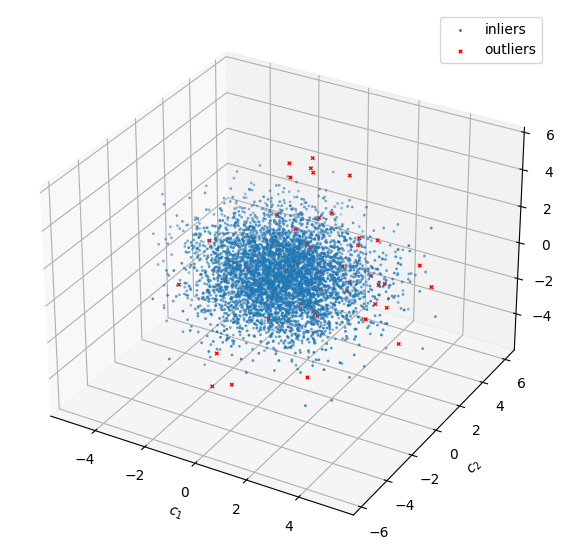

In [80]:
# Plot all the ground truth points together with the predictions

fig = plt.figure(figsize=(10,7))
#ax = plt.axes()
ax = fig.add_subplot(111, projection='3d')
#plt.title("Compressed data set")
ax.set_xlabel(r'$c_{1}$') ; ax.set_ylabel(r'$c_{2}$') ;ax.set_zlabel(r'$c_{3}$')

# Plot the compressed inliers data points
ax.scatter(X_reduce[y_true == 0, 0], X_reduce[y_true == 0, 1], zs=X_reduce[y_true == 0, 2], s=4, lw=0, label = "inliers")

# outliers
ax.scatter(X_reduce[y_true == 1, 0], X_reduce[y_true == 1, 1], zs=X_reduce[y_true == 1, 2], 
           lw=1, s=6, marker="x", c="red", alpha=1, label = "outliers")
ax.legend()
#fig.savefig('mixturePlot3D.png')   # save the figure to file
plt.show();
#plt.close(fig);    # close the figure window

Partition dataset:

In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, y_true, test_size=0.33, random_state=42)

print(X_train.shape)
print(X_test.shape)

print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(3350, 30)
(1650, 30)
(array([0, 1]), array([3318,   32]))
(array([0, 1]), array([1634,   16]))


### Model training and prediction

In [82]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[
    ('discrete' , Discretize(nbins = None, verbose = False)),      # step only needed if continous features are present
    ('model', BHAD(contamination = 0.01))
])

y_pred_train = pipe.fit_predict(X_train)
scores_train = pipe.decision_function(X_train)


-- Bayesian Histogram-based Anomaly Detector (BHAD) --

Fit BHAD on discretized data.
Input shape: (3350, 30)
One-hot encoding categorical features.
Matrix dimension after one-hot encoding: (3350, 504)
Finished training.
Score input data.
Score input data.


In [83]:
y_pred_test = pipe.predict(X_test)
scores_test = pipe.decision_function(X_test)


Score input data.
Apply fitted one-hot encoder.

Score input data.
Apply fitted one-hot encoder.


Plot score distribution:

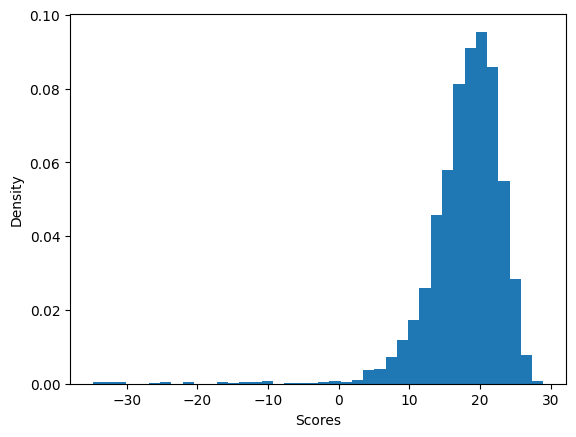

In [84]:
plt.hist(scores_train, density=True, bins=40) 
plt.ylabel('Density')
plt.xlabel('Scores');

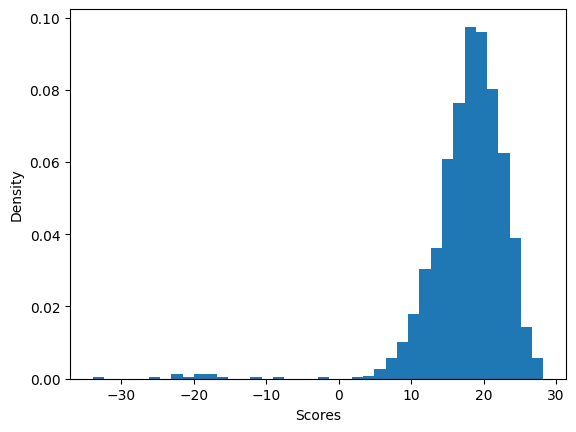

In [85]:
plt.hist(scores_test, density=True, bins=40) 
plt.ylabel('Density')
plt.xlabel('Scores');

In [86]:
from sklearn.metrics import classification_report

# Make comparable to y_true encoding
y_pred_train[y_pred_train == 1] = 0
y_pred_train[y_pred_train == -1] = 1

print(classification_report(y_train, y_pred_train, target_names=['Inlier', 'Outlier']))

              precision    recall  f1-score   support

      Inlier       1.00      1.00      1.00      3318
     Outlier       0.85      0.91      0.88        32

    accuracy                           1.00      3350
   macro avg       0.93      0.95      0.94      3350
weighted avg       1.00      1.00      1.00      3350



In [87]:
# Make comparable to y_true encoding
y_pred_test[y_pred_test == 1] = 0
y_pred_test[y_pred_test == -1] = 1

print(classification_report(y_test, y_pred_test, target_names=['Inlier', 'Outlier']))

              precision    recall  f1-score   support

      Inlier       1.00      1.00      1.00      1634
     Outlier       1.00      1.00      1.00        16

    accuracy                           1.00      1650
   macro avg       1.00      1.00      1.00      1650
weighted avg       1.00      1.00      1.00      1650



## Model explanation:

Retrieve local model explanations. Here: Specify all numeric and categorical columns explicitly

In [88]:
numeric_cols = list(X_train.select_dtypes(include=['float', 'int']).columns) 
cat_cols = list(X_train.select_dtypes(include=['object', 'category']).columns)

In [89]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(steps=[
    ('discrete', Discretize(nbins = None, verbose = True)),     
    ('model', BHAD(contamination = 0.01, numeric_features = numeric_cols, cat_features = cat_cols))
])

y_pred_train = pipe.fit_predict(X_train)


-- Bayesian Histogram-based Anomaly Detector (BHAD) --

Input shape: (3350, 30)
Used 30 numeric feature(s) and 0 categorical feature(s).
Determining optimal number of bins for numeric features
Feature var0 using 19 bins
Determining optimal number of bins for numeric features
Feature var1 using 19 bins
Determining optimal number of bins for numeric features
Feature var2 using 18 bins
Determining optimal number of bins for numeric features
Feature var3 using 18 bins
Determining optimal number of bins for numeric features
Feature var4 using 18 bins
Determining optimal number of bins for numeric features
Feature var5 using 23 bins
Determining optimal number of bins for numeric features
Feature var6 using 20 bins
Determining optimal number of bins for numeric features
Feature var7 using 16 bins
Determining optimal number of bins for numeric features
Feature var8 using 20 bins
Determining optimal number of bins for numeric features
Feature var9 using 19 bins
Determining optimal number of bi

In [105]:
from bhad import explainer

reload(explainer)

local_expl = explainer.Explainer(pipe.named_steps['model'], pipe.named_steps['discrete']).fit()

--- BHAD Model Explainer ---

Using fitted BHAD and discretizer.
Marginal distributions estimated using train set of shape (3350, 30)


In [106]:
df_train = local_expl.get_explanation(append = False)

df_train.head(5)

Create local explanations for 3350 observations.


  0%|          | 0/3350 [00:00<?, ?it/s]

0    var25 (Cumul.perc.: 0.988): 7.31\nvar10 (Cumul...
1    var3 (Cumul.perc.: 0.012): -5.31\nvar11 (Cumul...
2    var3 (Cumul.perc.: 0.0): -13.62\nvar8 (Cumul.p...
3    var25 (Cumul.perc.: 0.987): 7.2\nvar18 (Cumul....
4    var14 (Cumul.perc.: 0.997): 8.72\nvar7 (Cumul....
Name: explanation, dtype: object

In [107]:
global_feat_imp = local_expl.global_feat_imp         # based on X_train

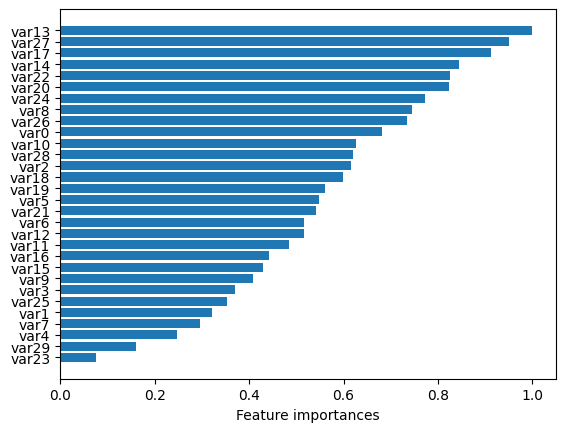

In [108]:
from matplotlib import pyplot as plt

plt.barh(global_feat_imp.index, global_feat_imp.values.flatten())
plt.xlabel("Feature importances");

plt.savefig('global_importances.png')   # save the figure to file
plt.show();
plt.close();    # close the figure window

In [109]:
y_pred_test = pipe.predict(X_test)


Score input data.
Apply fitted one-hot encoder.


In [110]:
df_test = local_expl.get_explanation()

Create local explanations for 1650 observations.


  0%|          | 0/1650 [00:00<?, ?it/s]

In [111]:
for obs, ex in enumerate(df_test.explanation.values):
    if (obs % 100) == 0:
        print(f'\nObs. {obs}:\n', ex)


Obs. 0:
 var5 (Cumul.perc.: 0.938): 5.32
var22 (Cumul.perc.: 0.1): -3.35
var23 (Cumul.perc.: 0.957): 5.89
var10 (Cumul.perc.: 0.881): 3.68
var13 (Cumul.perc.: 0.11): -3.35

Obs. 100:
 var6 (Cumul.perc.: 0.013): -7.16
var0 (Cumul.perc.: 0.027): -5.68
var10 (Cumul.perc.: 0.031): -4.85
var29 (Cumul.perc.: 0.037): -5.18
var17 (Cumul.perc.: 0.924): 4.67

Obs. 200:
 var13 (Cumul.perc.: 0.113): -3.31
var4 (Cumul.perc.: 0.076): -3.58
var3 (Cumul.perc.: 0.894): 3.94
var0 (Cumul.perc.: 0.856): 3.85
var5 (Cumul.perc.: 0.879): 4.06

Obs. 300:
 var25 (Cumul.perc.: 0.998): 9.8
var13 (Cumul.perc.: 0.037): -5.2
var19 (Cumul.perc.: 0.04): -4.7
var9 (Cumul.perc.: 0.956): 4.85
var26 (Cumul.perc.: 0.857): 3.69

Obs. 400:
 var16 (Cumul.perc.: 0.022): -5.41
var20 (Cumul.perc.: 0.892): 3.77
var8 (Cumul.perc.: 0.838): 3.12
var22 (Cumul.perc.: 0.856): 3.62
var13 (Cumul.perc.: 0.236): -1.81

Obs. 500:
 var2 (Cumul.perc.: 0.001): -9.47
var11 (Cumul.perc.: 0.993): 8.32
var24 (Cumul.perc.: 0.019): -6.01
var3 (Cum